# Results: Domain Randomization of Deep Reinforcement Learning Environments for Zero-Shot Traffic Signal Control

In [22]:
from collections import defaultdict
import itertools
import os
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)
from src.params import * 

## Data Preparation

In [5]:
dtypes = {"agent": str, "scenario": str, "checkpoint": str}
renaming = {"scenario": "specific_scenario"}

agent_stats = pd.read_csv(os.path.join(RESULTS_ROOT, "agent.csv.gz"), compression="gzip", dtype=dtypes).rename(columns=renaming)
agent_stats["scenario"] = agent_stats.apply(lambda row: row.specific_scenario.split("/")[0], axis=1)
print("Read agent stats done")

intersection_stats = pd.read_csv(os.path.join(RESULTS_ROOT, "intersection.csv.gz"), compression="gzip", dtype=dtypes).rename(columns=renaming)
intersection_stats["scenario"] = intersection_stats.apply(lambda row: row.specific_scenario.split("/")[0], axis=1)
print("Read intersection stats done")

vehicle_stats = pd.read_csv(os.path.join(RESULTS_ROOT, "vehicle.csv.gz"), compression="gzip", dtype=dtypes).rename(columns=renaming)
vehicle_stats["scenario"]= vehicle_stats.apply(lambda row: row.specific_scenario.split("/")[0], axis=1)
vehicle_stats["arrived"] = vehicle_stats["arrival_time"] != -1
vehicle_stats["travel_time"] = np.where(vehicle_stats["arrived"], vehicle_stats["arrival_time"] - vehicle_stats["departure_time"], np.nan) 
print("Read vehicle stats done")

Read agent stats done
Read intersection stats done


/var/tmp/ipykernel_3553686/1878752168.py:12: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicle_stats = pd.read_csv(os.path.join(RESULTS_ROOT, "vehicle.csv.gz"), compression="gzip", dtype=dtypes).rename(columns=renaming)


Read vehicle stats done


In [121]:
trainable_agents = sorted([agent for agent, agent_spec in agent_specs.items() if agent_spec.scenario_name is not None])
transferlight_agents = sorted([agent for agent in agent_specs.keys() if agent.startswith("TransferLight")])

In [7]:
def agent_group_agg(group: pd.DataFrame) -> pd.DataFrame:
    actions = list(itertools.chain(*[action_seq.split("|") for action_seq in group["action_seq"]]))
    actions = [int(action) for action in actions]
    mc_stds = [
        float(mc_stds.split("/")[action]) if mc_stds != "" else np.nan
        for action, mc_stds in
        zip(actions, list(itertools.chain(*[mc_means_seq.split("|") for mc_means_seq in group["mc_stds_seq"]])))
    ]
    return pd.DataFrame({"uncertainty": [np.mean(mc_stds)]})


def vehicle_group_agg(group: pd.DataFrame) -> pd.DataFrame:
    scenario_cnt = len(group["specific_scenario"].unique())
    throughput = np.sum(group["arrived"]) / scenario_cnt
    travel_time = np.mean(group["travel_time"])
    return pd.DataFrame({"throughput": [throughput], "travel_time": [travel_time]})


def intersection_group_agg(group: pd.DataFrame) -> pd.DataFrame:
    pressures = list(itertools.chain(*[pressure_seq.split("|") for pressure_seq in group["pressure_seq"]]))
    pressures = [int(pressure) for pressure in pressures]
    normalized_pressures = list(itertools.chain(*[pressure_seq.split("|") for pressure_seq in group["normalized_pressure_seq"]]))
    normalized_pressures = [float(pressure) for pressure in normalized_pressures]
    queue_lengths = list(itertools.chain(*[queue_length_seq.split("|") for queue_length_seq in group["queue_length_seq"]]))
    queue_lengths = [int(queue_length) for queue_length in queue_lengths]
    waiting_times = list(itertools.chain(*[waiting_time_seq.split("|") for waiting_time_seq in group["waiting_time_seq"]]))
    waiting_times = [float(waiting_times) for waiting_times in waiting_times]
    df = pd.DataFrame({"pressure": [np.mean(pressures)], "normalized_pressure": [np.mean(normalized_pressures)], 
                       "queue_length": [np.mean(queue_lengths)], "waiting_time": [np.mean(waiting_times)]})
    return df


agent_stats_ = (
    agent_stats
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(agent_group_agg)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

vehicle_stats_ = (
    vehicle_stats
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(vehicle_group_agg)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

intersection_stats_ = (
    intersection_stats
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(intersection_group_agg)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

stats = (
    vehicle_stats_
    .merge(agent_stats_, how="outer")
    .merge(intersection_stats_)
    .assign(reward=lambda x: -x["normalized_pressure"])
)
train_stats = (
    stats
    .query('checkpoint != "best"')
    .rename(columns={"checkpoint": "train_step"})
    .astype({"train_step": int})
    .assign(train_step=lambda x: x["train_step"]-100)
)
best_stats = (
    stats
    .query('checkpoint == "best"')
    .drop("checkpoint", axis=1)
)

## Training Stability

In [114]:
def plot_axes_training_curves(ax: plt.Axes, scenario: str, metric: str, baselines: List[str] = None):
    name_assignment = dict()
    color_assignment = defaultdict(lambda: "grey")
    linestyle_assignment = defaultdict(lambda: "solid")
    for agent in agent_specs.keys():
        if agent.startswith("TransferLight-A2C"):
            name_assignment[agent] = "TransferLight-A2C"
            color_assignment[agent] = "orange"
        elif agent.startswith("TransferLight-DQN"):
            name_assignment[agent] = "TransferLight-DQN"
            color_assignment[agent] = "blue"
        elif agent == "Random":
            linestyle_assignment[agent] = "dotted"
        elif agent == "MaxPressure":
            linestyle_assignment[agent] = "dashed"
            
    baselines = baselines if baselines is not None else ["MaxPressure", "Random"]
    for baseline in baselines:
        baseline_stats = best_stats.query(f'agent == "{baseline}" & scenario == "{scenario}"')
        ax.axhline(baseline_stats[metric].iat[0], label=baseline, linestyle=linestyle_assignment[baseline], color=color_assignment[baseline])
    scenario_train_stats = train_stats.query(f'scenario == "{scenario}"').sort_values(by=["agent", "train_step"])
    agents = scenario_train_stats.loc[:, "agent"].sort_values().unique()
    for agent in agents:
        agent_train_stats = scenario_train_stats.query(f"agent == '{agent}'")
        ax.plot(agent_train_stats["train_step"], agent_train_stats[metric], label=name_assignment[agent], color=color_assignment[agent])
    ax.set_title(scenario)


def plot_training_curves(metric: str, baselines: List[str] = None):
    axes_assignment = {
        (0, 0): "fixed-all",
        (0, 1): "random-location",
        (0, 2): "random-rate",
        (0, 3): "random-network",
        (1, 0): "random-all",
        (1, 1): "fixed-location",
        (1, 2): "fixed-rate",
        (1, 3): "fixed-network"
    }
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 5), sharex=True, sharey=True)
    
    handles, labels = None, None
    for r in range(2):
        for c in range(4):
            ax = axs[r, c]
            scenario = axes_assignment[(r, c)]
            plot_axes_training_curves(ax, scenario, metric, baselines)
            handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.07), fancybox=True, ncol=4)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("train step", fontsize=12)
    plt.ylabel(metric, fontsize=12)

### Reward (negative normalized pressure)

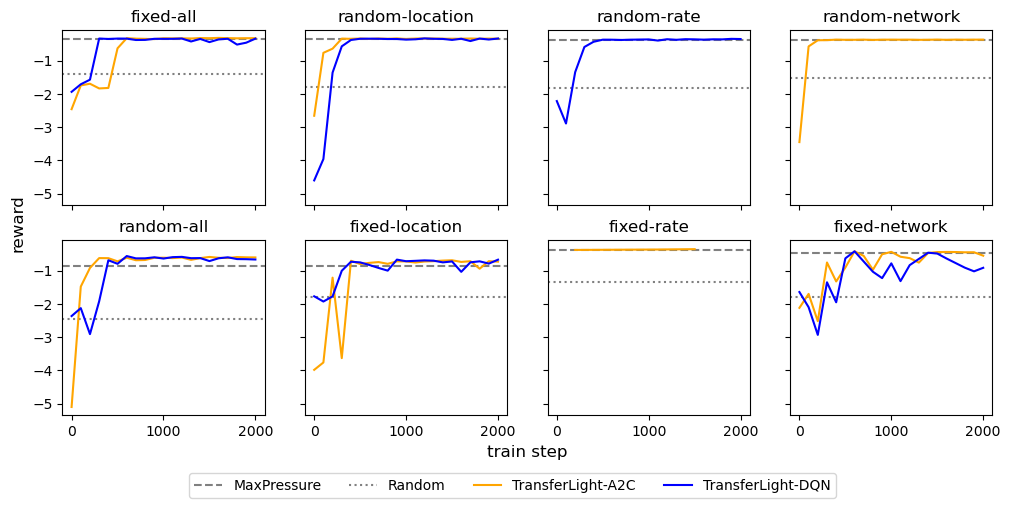

In [115]:
plot_training_curves("reward")

### Throughput

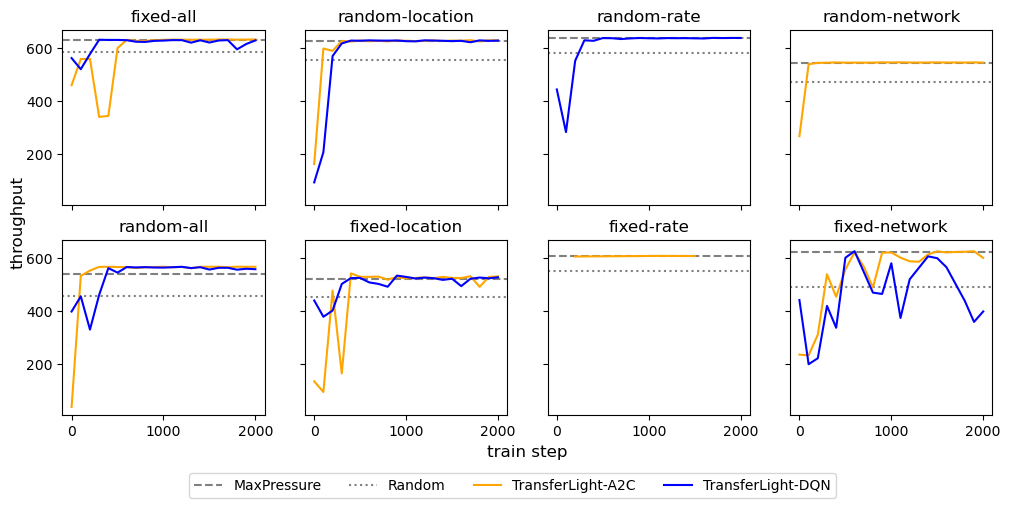

In [117]:
plot_training_curves("throughput")

## Travel Time

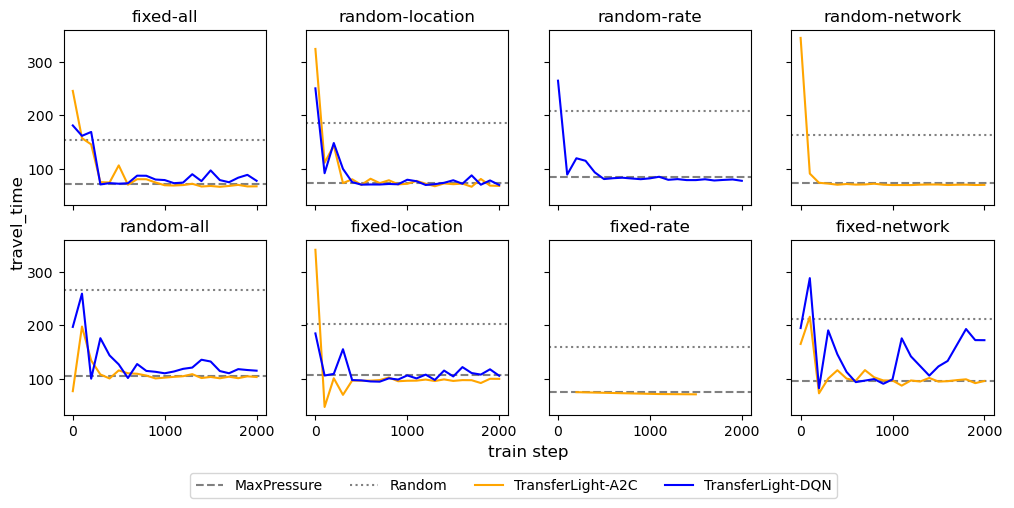

In [118]:
plot_training_curves("travel_time")

### Queue Length

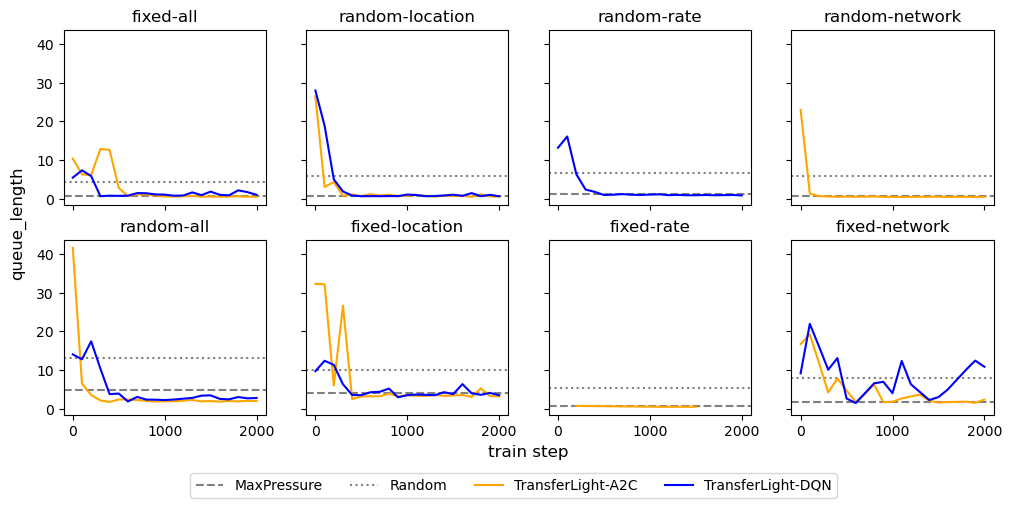

In [119]:
plot_training_curves("queue_length")

### Uncertainty

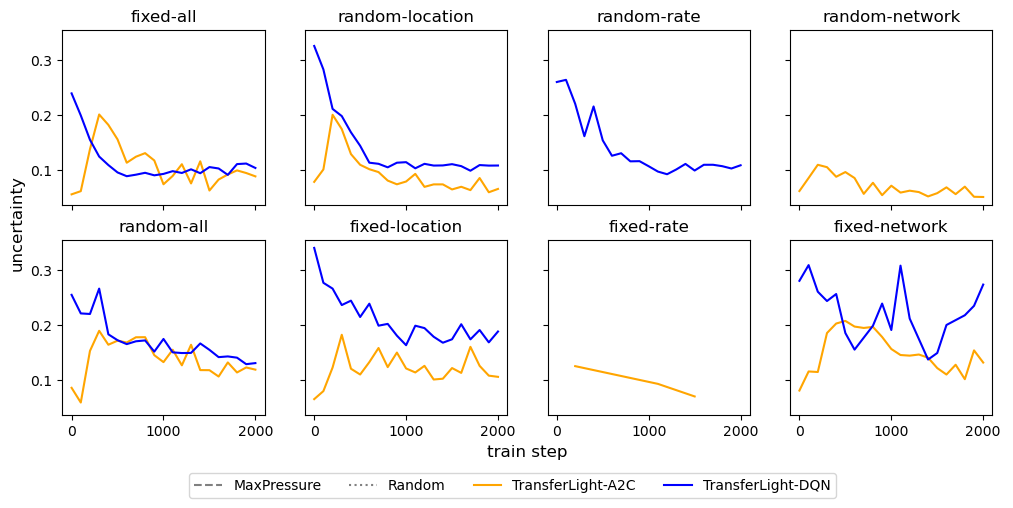

In [139]:
plot_training_curves("uncertainty")

## Policies with best performance on test set

In [138]:
def determine_best(group: pd.DataFrame, metric="throughput") -> pd.DataFrame:
    train_steps = list(group.loc[:, "train_step"])
    metrics = list(group.loc[:, metric])
    best_metric = np.max(metrics)
    best_train_step = train_steps[np.argmax(metrics)]
    best_checkpoint = str(best_train_step + 100)
    return pd.DataFrame({"checkpoint": [best_checkpoint], metric: [best_metric]})


trainable_best_stats = (
    train_stats
    .query(f'agent in @trainable_agents')
    .groupby(["agent", "scenario"])
    .apply(determine_best)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

trainable_best_stats

,agent,scenario,checkpoint,throughput
0,TransferLight-A2C-fixed-all,fixed-all,2100,631.8
1,TransferLight-A2C-fixed-location,fixed-location,500,541.9
2,TransferLight-A2C-fixed-network,fixed-network,2000,624.9
3,TransferLight-A2C-fixed-rate,fixed-rate,1200,607.5
4,TransferLight-A2C-random-all,random-all,1900,567.0
5,TransferLight-A2C-random-location,random-location,1800,629.0
6,TransferLight-A2C-random-network,random-network,1200,545.9
7,TransferLight-DQN-fixed-all,fixed-all,400,630.7
8,TransferLight-DQN-fixed-location,fixed-location,1000,533.6
9,TransferLight-DQN-fixed-network,fixed-network,700,625.3


## Performance Comparison

### Arterial Road Network 